In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Suppress ta warnings
import warnings
warnings.filterwarnings("ignore")

# Auto reload local files
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Make files in src/ available to notebook
import sys
if 'src' not in sys.path:
    sys.path.insert(0, 'src')

In [2]:
# Load the data
from sklearn.model_selection import train_test_split

import datastore as ds
from technical_signals import TechnicalSignalSet

spy_constituents = list(pd.read_csv('../../data/spy_constituents.csv', header=0)['Symbol'])
random.shuffle(spy_constituents)

tickers = spy_constituents
start_date = "2000-01-01"
end_date = "2025-01-01"
predict_window = 14

#ds.download_daily_candlesticks(tickers, start_date, end_date)
candlesticks = ds.get_daily_candlesticks(tickers, start_date, end_date)

Xs = []
ys = []

for ticker in tickers:
    try:
        technical_sigs = TechnicalSignalSet(candlesticks[ticker], predict_window)
        X, y, Xy_date = technical_sigs.to_xy()
        Xs.append(X)
        ys.append(y)
    except Exception as ex:
        print(f"Exception on {ticker}:")
        print(ex)

X = np.concatenate(Xs, axis=0)
y = np.concatenate(ys, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Exception on XLNX:
'high'
Exception on WLTW:
'high'
Exception on VIAC:
'high'
Exception on OGN:
Found array with 0 sample(s) (shape=(0, 58)) while a minimum of 1 is required by StandardScaler.
Exception on BF.B:
'high'
Exception on BRK.B:
'high'
Exception on PBCT:
'high'
Exception on DISCA:
'high'
Exception on INFO:
'high'
Exception on KSU:
'high'
Exception on DISCK:
'high'


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import gc


def round_batch_size(sample_count, approximately, leeway=None):
    """
    Round batch size to a more suitable value. This helps to avoid a
    problem where the final batch has a lot of samples, but not enough for
    a full batch, leading to many samples being thrown out.

    approximately: int, leeway: int
      decide on a chunk size around a number, with specified leeway
      (leeway defaults to `approximately // 10`).
    """
    if leeway is None:
        leeway = approximately // 10
    
    # Get the number of leftover samples if we use the suggested batch size
    best_leftover = sample_count - np.floor(sample_count / approximately) * approximately

    # Brute-force search for the value that yeilds the fewest leftovers
    # within the given leeway range.
    best_chunk_count = approximately
    for offset in range(-leeway, leeway):
        chunk_size = approximately + offset
        leftover = sample_count - np.floor(sample_count / chunk_size) * chunk_size
        if leftover < best_leftover:
            best_leftover = leftover
            best_chunk_count = chunk_size
    return best_chunk_count
            

batch_size = round_batch_size(X_train.shape[0], 1024, leeway=200)
n_features = X_train.shape[1]

# Convert X, y to torch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train.reshape(y_train.shape[0], 1)).float()
y_test_tensor = torch.from_numpy(y_test.reshape(y_test.shape[0], 1)).float()

print(X_train_tensor.shape)
print('Batch size:', batch_size)

# Generators
training_set = TensorDataset(X_train_tensor, y_train_tensor)
dataloader_train = DataLoader(training_set, shuffle=True, batch_size=batch_size)

validation_set = TensorDataset(X_test_tensor, y_test_tensor)
dataloader_test = DataLoader(validation_set, shuffle=True, batch_size=batch_size)

# Release duplicated memory
try:
    del X
    del y
    del Xs
    del ys
    #del X_train
    #del X_test
    #del y_train
    #del y_test
    del X_train_tensor
    del X_test_tensor
    del y_train_tensor
    del y_test_tensor
except:
    pass
gc.collect()

torch.Size([2056208, 58])
Batch size: 894


9

In [4]:
n_outputs = 1

net = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, n_outputs),
)

net = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, n_outputs),
)

In [5]:
device = "cuda"

# Set device for model
net = net.to(device)

# Select optimizerand loss criteria
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) 

# Training the model
for epoch in range(100):
    train_loss = 0.0
    
    # Training
    net.train()
    for local_batch, local_labels in dataloader_train:
        if local_batch.shape[0] != batch_size:
            print(f"Wrong train batch size. Skipping batch.\nThrowing away {local_batch.shape[0]} samples.")
            continue
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        # Forward pass: Compute predicted y by passing x to the model 
        y_pred = net(local_batch)
        # Compute and print loss 
        loss = criterion(y_pred, local_labels)
        # Zero gradients, perform a backward pass, update the weights. 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        # Update loss
        train_loss += loss.item()

    # Validation
    net.eval()
    valid_loss = 0.0
    for data, labels in dataloader_test:
        if data.shape[0] != batch_size:
            continue
        data, labels = data.to(device), labels.to(device)
        
        target = net(data)
        loss = criterion(target,labels)
        valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(dataloader_train)} \t\t Validation Loss: {valid_loss / len(dataloader_test)}')

Wrong train batch size. Skipping batch.
Throwing away 8 samples.
Epoch 1 		 Training Loss: 0.9270472286163025 		 Validation Loss: 0.903795407153666
Wrong train batch size. Skipping batch.
Throwing away 8 samples.
Epoch 2 		 Training Loss: 0.882083985583775 		 Validation Loss: 0.8803346916101873
Wrong train batch size. Skipping batch.
Throwing away 8 samples.
Epoch 3 		 Training Loss: 0.8595853082929575 		 Validation Loss: 0.8608372155576944
Wrong train batch size. Skipping batch.
Throwing away 8 samples.
Epoch 4 		 Training Loss: 0.8427855540803597 		 Validation Loss: 0.8477314482443035
Wrong train batch size. Skipping batch.
Throwing away 8 samples.
Epoch 5 		 Training Loss: 0.8286942817086191 		 Validation Loss: 0.8357432812917978
Wrong train batch size. Skipping batch.
Throwing away 8 samples.
Epoch 6 		 Training Loss: 0.8162025558280199 		 Validation Loss: 0.8262388051953167
Wrong train batch size. Skipping batch.
Throwing away 8 samples.
Epoch 7 		 Training Loss: 0.806118517738484

Ticker: T
135 buy/sells performed - 2.3696682464454977% of the time
Stock price change: -29.15129021521944%
Total gain/loss: -0.4927335739135742%
ROI: -2.6552148248521212%
{'cash': 8954.676609039307, 'assets': 55, 'latest_price': 18.110000610351562, 'total_value': 9950.726642608643, 'roi': -0.02655214824852121}


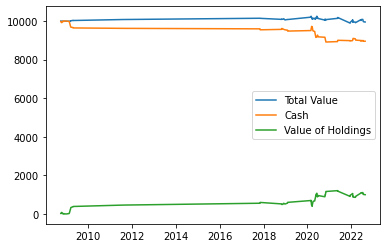

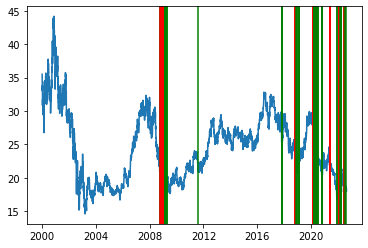

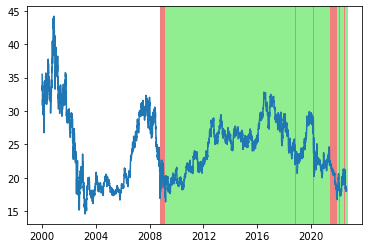

{'average_gainloss': -49.27335739135742,
 'results': {'T': {'cash': 8954.676609039307,
   'assets': 55,
   'latest_price': 18.110000610351562,
   'total_value': 9950.726642608643,
   'roi': -0.02655214824852121}}}

In [10]:
import backtest as bt
from strategy import PretrainedModelStrategy, SignalModelStrategy
from technical_signals import TechnicalSignalSet
from sklearn.svm import SVR

random.shuffle(spy_constituents)

# XXX temporary - need to rework concurrency to be suitable for PyTorch
net = net.to('cpu')

def predict(X):
    return net(torch.from_numpy(X).float()).detach().numpy()
def df_to_signal_set(df):
    return TechnicalSignalSet(df, predict_window=predict_window)
strategy = PretrainedModelStrategy(predict, df_to_signal_set, cutoff=0.8, bias=0.2)
#strategy = SignalModelStrategy(SVR(), lambda df: TechnicalSignalSet(df, predict_window=14), cutoff=1., bias=0.1)
bt.comprehensive_backtest(strategy, spy_constituents[-1:], "2000-01-01", "2025-01-01", plot=True, train_test_ratio=0.3)

In [7]:
import gc
gc.collect()

319